# Setup

In [11]:
import os, csv, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from rplidar import RPLidar

# Select LiDAR Points

In [ ]:
# ---------------------- LiDAR scan -> (x,y) ----------------------
def get_lidar_full_scan_xy(
    port='COM12',
    revolutions=10,
    min_m=0.10,
    max_m=12.0,
    bin_deg=None,        # e.g. 1 for 1° bins; None = keep all points
    slow_pwm=None        # e.g. 600..800 to slow motor (if supported)
):
    """
    Collects 'revolutions' full 360° turns using the 'new_scan' flag from iter_measurments().
    Returns xs, ys in meters. Optional angle binning for even spacing.
    """
    lidar = RPLidar(port)

    # Optional motor PWM (some adapters support this; safe to ignore if not)
    if slow_pwm is not None:
        for attr in ('set_pwm', 'set_motor_pwm'):
            if hasattr(lidar, attr):
                try:
                    getattr(lidar, attr)(int(slow_pwm))
                except Exception:
                    pass
                break

    xs_all, ys_all = [], []
    try:
        it = lidar.iter_measurments()  # yields (new_scan, quality, angle, distance)
        angles, dists = [], []
        turns_done = 0
        started = False

        for new_scan, quality, a_deg, dist_mm in it:
            # When 'new_scan' toggles True, a new revolution starts.
            if new_scan:
                if started and angles:
                    # finalize previous revolution
                    ang = np.deg2rad(np.array(angles, dtype=float))
                    d_m = np.array(dists, dtype=float) / 1000.0
                    mask = (d_m >= min_m) & (d_m <= max_m)
                    ang, d_m = ang[mask], d_m[mask]
                    xs = d_m * np.cos(ang)
                    ys = d_m * np.sin(ang)
                    xs_all.append(xs); ys_all.append(ys)
                    turns_done += 1
                    angles, dists = [], []
                    if turns_done >= revolutions:
                        break
                started = True  # we’re synced; start capturing this revolution

            if dist_mm > 0:
                angles.append(a_deg)
                dists.append(dist_mm)

    finally:
        try:
            lidar.stop()
            lidar.stop_motor()
        except Exception:
            pass
        lidar.disconnect()

    if not xs_all:
        return np.array([]), np.array([])

    xs = np.concatenate(xs_all)
    ys = np.concatenate(ys_all)

    # Optional: bin by angle for evenly spaced points (robust median per bin)
    if bin_deg is not None:
        ang_deg = (np.rad2deg(np.arctan2(ys, xs)) + 360.0) % 360.0
        bins = np.arange(0, 360, bin_deg)
        idx = np.digitize(ang_deg, bins, right=False) - 1
        idx = np.clip(idx, 0, len(bins) - 1)

        xs_b, ys_b = [], []
        for b in range(len(bins)):
            sel = (idx == b)
            if np.any(sel):
                xs_b.append(np.median(xs[sel]))
                ys_b.append(np.median(ys[sel]))
        xs = np.array(xs_b); ys = np.array(ys_b)

    return xs, ys
# ---------------------- LiDAR picker (OpenCV window) ----------------------
def pick_points_on_lidar_window(xs, ys, win_name="Pick LiDAR Points",
                                canvas_size=800, margin_px=40,
                                select_radius_m=0.15, grid_step_m=0.5):
    """
    Shows a 2D scatter of LiDAR points in an OpenCV window.
    Click to select points (stored in meters). Returns Nx2 array (x,y).
    """
    # Compute scale to fit points nicely
    r = np.sqrt(xs**2 + ys**2)
    r_show = np.percentile(r, 98) if r.size else 2.0
    r_show = max(r_show, 1.0)
    drawable = canvas_size - 2 * margin_px
    px_per_m = drawable / (2 * r_show)  # fits circle of radius r_show

    def world_to_canvas(x, y):
        # center in canvas, +x to right, +y up in world -> down in image
        cx = canvas_size // 2 + int(round(x * px_per_m))
        cy = canvas_size // 2 - int(round(y * px_per_m))
        return cx, cy

    def canvas_to_world(u, v):
        x = (u - canvas_size // 2) / px_per_m
        y = (canvas_size // 2 - v) / px_per_m
        return x, y

    pts_lidar = []  # selected in meters

    def draw_canvas(selected=None):
        img = np.full((canvas_size, canvas_size, 3), 255, np.uint8)

        # grid
        max_m = r_show
        m = -int(math.ceil(max_m))
        while m <= int(math.ceil(max_m)):
            # vertical x=m
            xw = m
            u1, v1 = world_to_canvas(xw, -max_m)
            u2, v2 = world_to_canvas(xw,  max_m)
            cv2.line(img, (u1,v1), (u2,v2), (230,230,230), 1)
            # horizontal y=m
            yw = m
            u1, v1 = world_to_canvas(-max_m, yw)
            u2, v2 = world_to_canvas( max_m, yw)
            cv2.line(img, (u1,v1), (u2,v2), (230,230,230), 1)
            # axis labels
            if m != 0:
                u,v = world_to_canvas(xw,0)
                cv2.putText(img, f"{m}", (u+2, v-2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200,200,200), 1, cv2.LINE_AA)
                u,v = world_to_canvas(0,yw)
                cv2.putText(img, f"{m}", (u+2, v-2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200,200,200), 1, cv2.LINE_AA)
            m += grid_step_m

        # axes
        u1,v1 = world_to_canvas(-max_m,0); u2,v2 = world_to_canvas(max_m,0)
        cv2.line(img,(u1,v1),(u2,v2),(180,180,180),2)
        u1,v1 = world_to_canvas(0,-max_m); u2,v2 = world_to_canvas(0,max_m)
        cv2.line(img,(u1,v1),(u2,v2),(180,180,180),2)

        # raw points
        for x,y in zip(xs,ys):
            u,v = world_to_canvas(x,y)
            cv2.circle(img,(u,v),1,(100,100,100),-1)

        # selected points with indices
        if selected:
            for i,(x,y) in enumerate(selected, start=1):
                u,v = world_to_canvas(x,y)
                cv2.circle(img,(u,v),4,(0,0,255),-1)
                cv2.putText(img, f"{i}", (u+6, v-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

        # help
        cv2.putText(img, "LiDAR: L-click add, R-click remove, u=undo, c=clear, s=save, q/ESC=finish",
                    (10, canvas_size-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (70,70,70), 1, cv2.LINE_AA)
        return img

    def nearest_idx_world(x0,y0, points_world):
        if not points_world:
            return -1, 1e9
        d2 = [(x-x0)**2 + (y-y0)**2 for x,y in points_world]
        j = int(np.argmin(d2))
        return j, math.sqrt(d2[j])

    # For snapping, we use the actual LiDAR cloud (xs,ys)
    def nearest_idx_cloud(x0,y0):
        if xs.size == 0:
            return -1, 1e9
        d2 = (xs - x0)**2 + (ys - y0)**2
        j = int(np.argmin(d2))
        return j, math.sqrt(d2[j])

    cv2.namedWindow(win_name, cv2.WINDOW_AUTOSIZE)
    canvas = draw_canvas(pts_lidar)
    cv2.imshow(win_name, canvas)

    while True:
        key = cv2.waitKey(20) & 0xFF
        if key in (27, ord('q')):  # ESC or q
            break
        elif key == ord('u'):
            if pts_lidar:
                pts_lidar.pop()
            canvas = draw_canvas(pts_lidar)
            cv2.imshow(win_name, canvas)
        elif key == ord('c'):
            pts_lidar.clear()
            canvas = draw_canvas(pts_lidar)
            cv2.imshow(win_name, canvas)
        elif key == ord('s'):
            if pts_lidar:
                with open("lidar_points.csv","w",newline="") as f:
                    w = csv.writer(f); w.writerow(["idx","x_m","y_m"])
                    for i,(x,y) in enumerate(pts_lidar,1):
                        w.writerow([i,x,y])
                print("Saved lidar_points.csv")

        # Mouse handling
        def on_mouse(event, x, y, flags, param):
            nonlocal canvas, pts_lidar
            if event == cv2.EVENT_LBUTTONDOWN:
                # map click to world, snap to nearest LiDAR sample
                xw, yw = canvas_to_world(x, y)
                j, d = nearest_idx_cloud(xw, yw)
                if d <= select_radius_m:
                    cand = (float(xs[j]), float(ys[j]))
                    # avoid duplicates (within small epsilon)
                    if not pts_lidar or min(( (cand[0]-px)**2+(cand[1]-py)**2 for px,py in pts_lidar )) > (0.01**2):
                        pts_lidar.append(cand)
                        print(f"Added #{len(pts_lidar)}: ({cand[0]:.3f}, {cand[1]:.3f}) m")
                    else:
                        print("Point already selected (near-duplicate).")
                else:
                    print("No LiDAR point within selection radius.")
                canvas = draw_canvas(pts_lidar)
                cv2.imshow(win_name, canvas)
            elif event == cv2.EVENT_RBUTTONDOWN:
                xw, yw = canvas_to_world(x, y)
                j, d = nearest_idx_world(xw, yw, pts_lidar)
                if j != -1 and d <= select_radius_m:
                    removed = pts_lidar.pop(j)
                    print("Removed:", removed)
                    canvas = draw_canvas(pts_lidar)
                    cv2.imshow(win_name, canvas)

        cv2.setMouseCallback(win_name, on_mouse)

    cv2.destroyWindow(win_name)
    return np.asarray(pts_lidar, dtype=np.float32)

# Select Camera Points

In [13]:
def pick_points_on_image_window(img_path, win_name="Pick Image Points"):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    pts = []
    radius = 5
    font = cv2.FONT_HERSHEY_SIMPLEX

    def draw_overlay():
        vis = img.copy()
        for i,(u,v) in enumerate(pts, start=1):
            cv2.circle(vis, (u,v), radius, (0,255,0), -1)
            cv2.putText(vis, f"{i}:({u},{v})", (u+8, v-8), font, 0.5, (0,255,0), 1, cv2.LINE_AA)
        cv2.putText(vis, "Image: L-click add, R-click remove, u=undo, c=clear, s=save, q/ESC=finish",
                    (10, 20), font, 0.5, (0,200,0), 1, cv2.LINE_AA)
        return vis

    def nearest_idx(u0, v0):
        if not pts:
            return -1, 1e18
        d2 = [(u-u0)**2+(v-v0)**2 for (u,v) in pts]
        j = int(np.argmin(d2))
        return j, d2[j]

    cv2.namedWindow(win_name, cv2.WINDOW_AUTOSIZE)
    vis = draw_overlay()
    cv2.imshow(win_name, vis)

    while True:
        key = cv2.waitKey(20) & 0xFF
        if key in (27, ord('q')):
            break
        elif key == ord('u'):
            if pts:
                print("Undo:", pts.pop())
                cv2.imshow(win_name, draw_overlay())
        elif key == ord('c'):
            pts.clear()
            cv2.imshow(win_name, draw_overlay())
        elif key == ord('s'):
            if pts:
                base = os.path.splitext(os.path.basename(img_path))[0]
                out = f"{base}_points.csv"
                with open(out, "w", newline="") as f:
                    w = csv.writer(f); w.writerow(["idx","u","v"])
                    for i,(u,v) in enumerate(pts,1):
                        w.writerow([i,u,v])
                print(f"Saved {out}")

        def on_mouse(event, x, y, flags, param):
            nonlocal vis, pts
            if event == cv2.EVENT_LBUTTONDOWN:
                pts.append((x,y))
                print(f"Added #{len(pts)}: ({x}, {y})")
                cv2.imshow(win_name, draw_overlay())
            elif event == cv2.EVENT_RBUTTONDOWN:
                j, d2 = nearest_idx(x,y)
                if j != -1 and d2 <= 10**2:
                    removed = pts.pop(j)
                    print("Removed:", removed)
                    cv2.imshow(win_name, draw_overlay())

        cv2.setMouseCallback(win_name, on_mouse)

    cv2.destroyWindow(win_name)
    if not pts:
        print("No image points selected.")
        return np.zeros((0,2), dtype=np.float32)
    return np.asarray(pts, dtype=np.float32)

# Compute Homography

In [14]:
def project_xy_to_uv(xy_m, H):
    """xy_m: (N,2) in meters (LiDAR plane) → (N,2) pixels using homography H."""
    if xy_m.size == 0:
        return np.zeros((0,2), dtype=float)
    ones = np.ones((xy_m.shape[0], 1), dtype=float)
    XY1  = np.hstack([xy_m, ones])          # (N,3)
    UVW  = (H @ XY1.T).T                    # (N,3)
    UV   = UVW[:, :2] / UVW[:, [2]]         # divide by w
    return UV

def overlay_all_lidar_points_on_image(
        H, img_path,
        xs_full, ys_full,                 # ALL lidar points from full revolution(s) in meters
        pts_lidar_xy_sel=None,            # optional: selected LiDAR points (for debugging)
        full_color=(0, 0, 255),           # red for all-points (BGR)
        sel_color=(0, 255, 0),            # green for selected (BGR)
        dot_radius=1,
        sel_radius=3,
        save_path="lidar_all_on_image.png"
    ):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    H_img, W_img = img.shape[:2]

    # Project ALL LiDAR points
    xy_full = np.column_stack([xs_full, ys_full]).astype(float)
    uv_full = project_xy_to_uv(xy_full, H)

    # Draw all points (clip to image bounds)
    overlay = img.copy()
    uv_int = uv_full.astype(int)
    inside = (uv_int[:,0] >= 0) & (uv_int[:,0] < W_img) & (uv_int[:,1] >= 0) & (uv_int[:,1] < H_img)
    for (u, v) in uv_int[inside]:
        overlay = cv2.circle(overlay, (u, v), dot_radius, full_color, -1)

    # Optionally draw selected correspondences (helps sanity-check)
    if pts_lidar_xy_sel is not None and len(pts_lidar_xy_sel) > 0:
        uv_sel = project_xy_to_uv(pts_lidar_xy_sel.astype(float), H).astype(int)
        for (u, v) in uv_sel:
            if 0 <= u < W_img and 0 <= v < H_img:
                overlay = cv2.circle(overlay, (u, v), sel_radius, sel_color, -1)

    cv2.imwrite(save_path, overlay)
    print(f"Saved: {save_path}")

    # Quick show
    cv2.imshow("LiDAR → Image overlay (ALL points)", overlay)
    cv2.waitKey(0)
    cv2.destroyWindow("LiDAR → Image overlay (ALL points)")

    # Also show inline if you're in a notebook
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("All LiDAR points projected into image")
    plt.show()


# Run the Full Flow

In [15]:
# ========================== RUN FLOW ==========================
# 1) One LiDAR scan
xs_full, ys_full = get_lidar_full_scan_xy(port='COM12', revolutions=1, min_m=0.2, max_m=12.0)

# 2) Pick LiDAR points (meters)
pts_lidar_xy = pick_points_on_lidar_window(xs_full, ys_full, select_radius_m=0.15)

# 3) Pick image points (pixels), same count & order
IMG_PATH = "./lidar_camera.jpg"  # change to your image
pts_img_uv = pick_points_on_image_window(IMG_PATH)

Added #1: (0.503, 0.172) m
Added #2: (0.491, -0.233) m
Added #3: (0.256, -0.228) m
Added #4: (0.248, -0.293) m
Added #5: (-0.395, -0.282) m
Added #6: (-0.440, 0.216) m
Added #7: (-0.174, 0.215) m
Added #8: (-0.166, 0.572) m
Added #9: (0.260, 0.543) m
Added #10: (0.243, 0.188) m
Added #1: (228, 240)
Added #2: (175, 279)
Added #3: (216, 293)
Added #4: (203, 312)
Added #5: (387, 370)
Added #6: (416, 266)
Added #7: (364, 260)
Added #8: (390, 223)
Added #9: (306, 211)
Added #10: (275, 246)


# Run Full Workflow

H:
 [[-121.24017809  309.64071238  303.85705728]
 [  34.35603266   36.39337184  277.27564075]
 [   0.32518665    0.64778167    1.        ]]
Inliers: 10 / 10
Saved: lidar_all_on_image.png


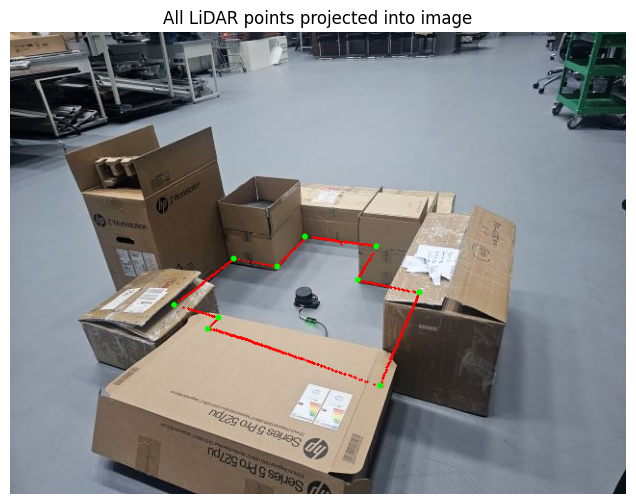

In [16]:
# 4) Compute H & show overlay
if len(pts_lidar_xy) >= 4 and len(pts_lidar_xy) == len(pts_img_uv):
    H, mask = cv2.findHomography(
    pts_lidar_xy.astype(np.float32),
    pts_img_uv.astype(np.float32),
    )
    print("H:\n", H)
    print("Inliers:", int(mask.sum()), "/", len(mask))
    overlay_all_lidar_points_on_image(
    H=H,
    img_path=IMG_PATH,
    xs_full=xs_full,
    ys_full=ys_full,
    pts_lidar_xy_sel=pts_lidar_xy,   # optional: highlights the clicked pairs
    save_path="lidar_all_on_image.png"
)
else:
    print("Need equal counts >= 4 in both sets.")